In [1]:
import tensorflow as tf

print(tf.__version__)

from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.layers                import *
from tensorflow.keras.preprocessing.image   import ImageDataGenerator
from tensorflow.keras.utils                 import to_categorical
from tensorflow.keras.optimizers            import SGD, RMSprop, Adam, Adagrad, Adadelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import random
# import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
import scipy
import skimage
from skimage.transform import resize
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

2023-09-16 01:31:41.039588: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-16 01:31:44.724178: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-16 01:31:44.724365: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

2.11.0


In [2]:
# !git clone https://github.com/EricMartinezIllamola/asl-alphabet.git

In [3]:
# !pip install split-folders 

In [4]:
# import splitfolders
# import os

In [5]:
# path = "asl-alphabet/asl-alphabet"

# splitfolders.ratio(path, seed=777, output="Train-Validation-Test-Dataset", ratio=(0.6, 0.2, 0.2))

In [6]:
train_path = "Train-Validation-Test-Dataset/train"
val_path = "Train-Validation-Test-Dataset/val"
test_path = "Train-Validation-Test-Dataset/test"

In [7]:
tf.config.experimental.list_physical_devices()

2023-09-16 01:31:49.353245: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-16 01:31:49.353295: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-16 01:31:49.353350: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (83cd76c86ffd): /proc/driver/nvidia/version does not exist


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [8]:
tf.test.is_built_with_cuda()

True

In [9]:
from tensorflow.keras.preprocessing.image   import ImageDataGenerator

##Clasificamos las imagenes
bs = 64 #bach size
k = 2
# Generador de imágenes de entrenamiento.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=(0.3),
        zoom_range=(0.3),
        width_shift_range=(0.2),
        height_shift_range=(0.2),
        # validation_split = 0.2,
        brightness_range=(0.05,0.85),
        horizontal_flip=False)

# Carga de imágenes al generador de entrenamiento desde directorio.
train_generator = train_datagen.flow_from_directory(
        train_path,
        class_mode='categorical',
        shuffle=True,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'training',
        batch_size=bs)

valid_generator = train_datagen.flow_from_directory(
        val_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

test_generator = train_datagen.flow_from_directory(
        test_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

Found 44695 images belonging to 24 classes.
Found 14892 images belonging to 24 classes.
Found 14921 images belonging to 24 classes.


In [10]:
#Visualizamos la estructura del modelo que vamos a utilizar
model = tf.keras.applications.VGG19()
model.summary()
print(len(model.layers))

2023-09-16 01:31:57.242032: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
##DEFINIMOS EL MODELO
num_classes = 24
epochs = 25

# VGG19
# Importamos el modelo que queremos utilizar con los argumentos que queremos
VGG19_model = tf.keras.applications.VGG19(input_shape=(28*k,28*k,3),
                                          include_top=False,
                                          weights='imagenet')

print(len(VGG19_model.layers))
#Congelamos  las 6 primeras caps del modelo para proceder a entrenar las demás
for layer in VGG19_model.layers[:6]:
  layer.trainable = False

# Creamos un nuevo modelo vacio.
model = tf.keras.Sequential()

# Añadimos el modelo preentrenado como si se tratase de una capa.
model.add(VGG19_model)

# Continuamos añadiendo más capas que sí serán entrenadas...
from tensorflow.keras import regularizers
model.add(Flatten())
model.add(Dense(512, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation = 'softmax'))

22


In [12]:
## EJECUCION DEL MODELO
# with tf.device("/CPU:0"):
# with tf.device("/GPU:0"):
model.compile(loss="categorical_crossentropy", 
              optimizer= SGD(learning_rate=0.001),
              metrics=['accuracy'])

#Agregamos un callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

checkpointer = ModelCheckpoint(filepath='model-00', verbose=1, save_best_only=True,
                               monitor = 'accuracy', mode = 'max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=3, min_lr=0.000001)

history= model.fit(train_generator, callbacks = [reduce_lr, checkpointer], epochs=epochs)

Epoch 1/25
699/699 [==============================] - ETA: 0s - loss: 7.8935 - accuracy: 0.1619
Epoch 1: accuracy improved from -inf to 0.16185, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


699/699 [==============================] - 1783s 3s/step - loss: 7.8935 - accuracy: 0.1619 - lr: 0.0010
Epoch 2/25
699/699 [==============================] - ETA: 0s - loss: 6.4082 - accuracy: 0.5360
Epoch 2: accuracy improved from 0.16185 to 0.53603, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


699/699 [==============================] - 1727s 2s/step - loss: 6.4082 - accuracy: 0.5360 - lr: 0.0010
Epoch 3/25
699/699 [==============================] - ETA: 0s - loss: 5.6529 - accuracy: 0.7263
Epoch 3: accuracy improved from 0.53603 to 0.72628, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


699/699 [==============================] - 1723s 2s/step - loss: 5.6529 - accuracy: 0.7263 - lr: 0.0010
Epoch 4/25
699/699 [==============================] - ETA: 0s - loss: 5.2842 - accuracy: 0.7985
Epoch 4: accuracy improved from 0.72628 to 0.79848, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


699/699 [==============================] - 1711s 2s/step - loss: 5.2842 - accuracy: 0.7985 - lr: 0.0010
Epoch 5/25
699/699 [==============================] - ETA: 0s - loss: 5.0303 - accuracy: 0.8422
Epoch 5: accuracy improved from 0.79848 to 0.84220, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


699/699 [==============================] - 1705s 2s/step - loss: 5.0303 - accuracy: 0.8422 - lr: 0.0010
Epoch 6/25
699/699 [==============================] - ETA: 0s - loss: 4.8303 - accuracy: 0.8609
Epoch 6: accuracy improved from 0.84220 to 0.86095, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


699/699 [==============================] - 1695s 2s/step - loss: 4.8303 - accuracy: 0.8609 - lr: 0.0010
Epoch 7/25
699/699 [==============================] - ETA: 0s - loss: 4.6562 - accuracy: 0.8800
Epoch 7: accuracy improved from 0.86095 to 0.88001, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


699/699 [==============================] - 1694s 2s/step - loss: 4.6562 - accuracy: 0.8800 - lr: 0.0010
Epoch 8/25
699/699 [==============================] - ETA: 0s - loss: 4.4980 - accuracy: 0.8933
Epoch 8: accuracy improved from 0.88001 to 0.89334, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


699/699 [==============================] - 1725s 2s/step - loss: 4.4980 - accuracy: 0.8933 - lr: 0.0010
Epoch 9/25
699/699 [==============================] - ETA: 0s - loss: 4.3505 - accuracy: 0.9024
Epoch 9: accuracy improved from 0.89334 to 0.90238, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


699/699 [==============================] - 1770s 3s/step - loss: 4.3505 - accuracy: 0.9024 - lr: 0.0010
Epoch 10/25
699/699 [==============================] - ETA: 0s - loss: 4.2148 - accuracy: 0.9104
Epoch 10: accuracy improved from 0.90238 to 0.91042, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


699/699 [==============================] - 1739s 2s/step - loss: 4.2148 - accuracy: 0.9104 - lr: 0.0010
Epoch 11/25
699/699 [==============================] - ETA: 0s - loss: 4.0889 - accuracy: 0.9176
Epoch 11: accuracy improved from 0.91042 to 0.91757, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


699/699 [==============================] - 1761s 3s/step - loss: 4.0889 - accuracy: 0.9176 - lr: 0.0010
Epoch 12/25
699/699 [==============================] - ETA: 0s - loss: 3.9665 - accuracy: 0.9230
Epoch 12: accuracy improved from 0.91757 to 0.92301, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


699/699 [==============================] - 1755s 3s/step - loss: 3.9665 - accuracy: 0.9230 - lr: 0.0010
Epoch 13/25
699/699 [==============================] - ETA: 0s - loss: 3.8469 - accuracy: 0.9278
Epoch 13: accuracy improved from 0.92301 to 0.92775, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


699/699 [==============================] - 1748s 3s/step - loss: 3.8469 - accuracy: 0.9278 - lr: 0.0010
Epoch 14/25
699/699 [==============================] - ETA: 0s - loss: 3.7373 - accuracy: 0.9305
Epoch 14: accuracy improved from 0.92775 to 0.93053, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


699/699 [==============================] - 1709s 2s/step - loss: 3.7373 - accuracy: 0.9305 - lr: 0.0010
Epoch 15/25
699/699 [==============================] - ETA: 0s - loss: 3.6245 - accuracy: 0.9361
Epoch 15: accuracy improved from 0.93053 to 0.93606, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


699/699 [==============================] - 1695s 2s/step - loss: 3.6245 - accuracy: 0.9361 - lr: 0.0010
Epoch 16/25
699/699 [==============================] - ETA: 0s - loss: 3.5249 - accuracy: 0.9384
Epoch 16: accuracy improved from 0.93606 to 0.93845, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


699/699 [==============================] - 1713s 2s/step - loss: 3.5249 - accuracy: 0.9384 - lr: 0.0010
Epoch 17/25
699/699 [==============================] - ETA: 0s - loss: 3.4206 - accuracy: 0.9416
Epoch 17: accuracy improved from 0.93845 to 0.94163, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


699/699 [==============================] - 1710s 2s/step - loss: 3.4206 - accuracy: 0.9416 - lr: 0.0010
Epoch 18/25
699/699 [==============================] - ETA: 0s - loss: 3.3254 - accuracy: 0.9447
Epoch 18: accuracy improved from 0.94163 to 0.94474, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


699/699 [==============================] - 1697s 2s/step - loss: 3.3254 - accuracy: 0.9447 - lr: 0.0010
Epoch 19/25
699/699 [==============================] - ETA: 0s - loss: 3.2306 - accuracy: 0.9464
Epoch 19: accuracy improved from 0.94474 to 0.94644, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


699/699 [==============================] - 1709s 2s/step - loss: 3.2306 - accuracy: 0.9464 - lr: 0.0010
Epoch 20/25
699/699 [==============================] - ETA: 0s - loss: 3.1427 - accuracy: 0.9471
Epoch 20: accuracy improved from 0.94644 to 0.94711, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


699/699 [==============================] - 1723s 2s/step - loss: 3.1427 - accuracy: 0.9471 - lr: 0.0010
Epoch 21/25
699/699 [==============================] - ETA: 0s - loss: 3.0566 - accuracy: 0.9498
Epoch 21: accuracy improved from 0.94711 to 0.94977, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


699/699 [==============================] - 1729s 2s/step - loss: 3.0566 - accuracy: 0.9498 - lr: 0.0010
Epoch 22/25
699/699 [==============================] - ETA: 0s - loss: 2.9680 - accuracy: 0.9519
Epoch 22: accuracy improved from 0.94977 to 0.95185, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


699/699 [==============================] - 1744s 2s/step - loss: 2.9680 - accuracy: 0.9519 - lr: 0.0010
Epoch 23/25
699/699 [==============================] - ETA: 0s - loss: 2.8821 - accuracy: 0.9548
Epoch 23: accuracy improved from 0.95185 to 0.95478, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


699/699 [==============================] - 1760s 3s/step - loss: 2.8821 - accuracy: 0.9548 - lr: 0.0010
Epoch 24/25
699/699 [==============================] - ETA: 0s - loss: 2.8087 - accuracy: 0.9542
Epoch 24: accuracy did not improve from 0.95478
699/699 [==============================] - 1740s 2s/step - loss: 2.8087 - accuracy: 0.9542 - lr: 0.0010
Epoch 25/25
699/699 [==============================] - ETA: 0s - loss: 2.7267 - accuracy: 0.9569
Epoch 25: accuracy improved from 0.95478 to 0.95691, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


699/699 [==============================] - 1743s 2s/step - loss: 2.7267 - accuracy: 0.9569 - lr: 0.0010


In [13]:
preds_test = model.predict(test_generator)

234/234 [==============================] - 157s 671ms/step


In [14]:
evaluate_test = model.evaluate(test_generator)

234/234 [==============================] - 157s 669ms/step - loss: 2.6920 - accuracy: 0.9569


In [15]:
evaluate_test

[2.69199538230896, 0.9569063782691956]

In [16]:
y_preds_test = np.array([np.argmax(x) for x in preds_test])
y_preds_test

array([ 0,  2,  0, ..., 23, 23, 23])

In [17]:
y_real_test = test_generator.classes
y_real_test

array([ 0,  0,  0, ..., 23, 23, 23], dtype=int32)

In [18]:
accuracy_test = accuracy_score(y_real_test, y_preds_test)
accuracy_test

0.9579116681187588

In [19]:
cm_test = confusion_matrix(y_real_test, y_preds_test)
cm_test

array([[592,   1,   3,   1,   5,   3,   0,   0,   1,   0,   0,   0,   2,
          3,   1,   0,   0,   3,   2,   0,   0,   1,   1,   1],
       [  0, 602,   2,   4,   4,   0,   0,   0,   1,   2,   0,   1,   0,
          0,   0,   0,   4,   0,   0,   3,   0,   0,   0,   0],
       [  2,   2, 620,   4,   1,   3,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   2,   0, 613,   2,   0,   0,   0,   1,   1,   0,   0,   0,
          1,   0,   0,   1,   0,   0,   0,   1,   0,   0,   0],
       [  5,  10,   0,   3, 580,   1,   0,   1,  10,   2,   1,   6,   0,
          2,   1,   0,   2,  11,   1,   0,   0,   0,   0,   1],
       [  0,   0,   0,   0,   1, 609,   2,   1,   2,   2,   1,   0,   0,
          1,   1,   0,   1,   1,   0,   0,   0,   0,   1,   1],
       [  0,   1,   0,   0,   0,   0, 608,  10,   2,   0,   0,   0,   0,
          0,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   4

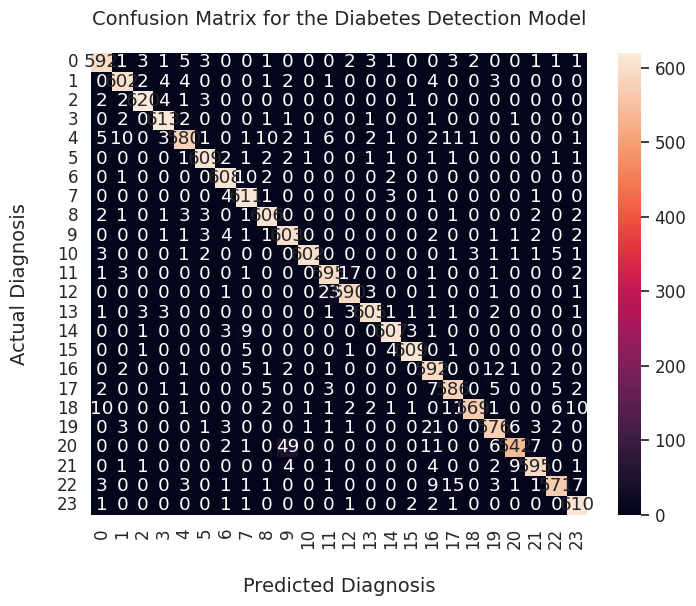

In [20]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_test, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()

In [21]:
preds_val = model.predict(valid_generator)

233/233 [==============================] - 156s 668ms/step


In [22]:
evaluate_val = model.evaluate(valid_generator)

233/233 [==============================] - 154s 661ms/step - loss: 2.6764 - accuracy: 0.9623


In [23]:
evaluate_val

[2.6764278411865234, 0.9623287916183472]

In [24]:
y_preds_val = np.array([np.argmax(x) for x in preds_val])
y_preds_val

array([ 2,  1,  2, ..., 23, 23, 23])

In [25]:
y_real_val = valid_generator.classes
y_real_val

array([ 0,  0,  0, ..., 23, 23, 23], dtype=int32)

In [26]:
accuracy_val = accuracy_score(y_real_val, y_preds_val)
accuracy_val

0.9619930163846361

In [27]:
cm_val = confusion_matrix(y_real_val, y_preds_val)
cm_val

array([[599,   4,   3,   0,   3,   1,   0,   0,   0,   0,   0,   1,   1,
          1,   0,   0,   0,   3,   1,   0,   0,   0,   0,   1],
       [  0, 608,   2,   5,   0,   0,   0,   0,   1,   1,   0,   1,   0,
          0,   0,   0,   3,   0,   0,   0,   0,   0,   0,   0],
       [  3,   0, 621,   3,   1,   1,   0,   0,   1,   0,   0,   0,   0,
          1,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0],
       [  0,   1,   1, 613,   1,   1,   0,   0,   0,   0,   0,   0,   0,
          1,   0,   0,   0,   0,   0,   2,   0,   0,   0,   0],
       [  1,   8,   1,   2, 587,   1,   0,   0,   9,   0,   0,   4,   2,
          3,   0,   0,   6,  10,   1,   0,   0,   0,   1,   1],
       [  0,   0,   0,   0,   1, 608,   5,   1,   2,   2,   0,   0,   0,
          0,   0,   0,   2,   0,   0,   0,   1,   0,   0,   0],
       [  0,   0,   0,   0,   0,   1, 599,  19,   0,   0,   0,   0,   0,
          0,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   9

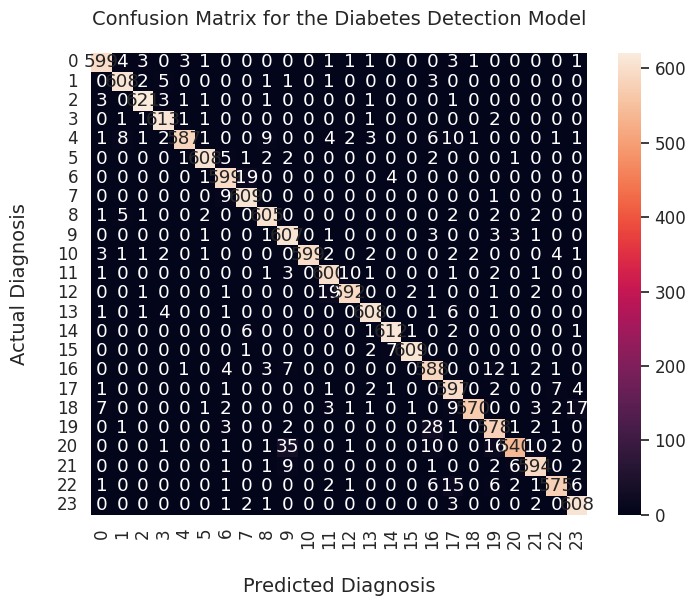

In [28]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_val, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()